In [3]:
import os
import collections
import random
import math
import click
import numpy as np
import tensorflow as tf
from six.moves import xrange
import mlflow
from scipy.spatial import distance
from scipy.stats import kurtosis, skew
from bokeh.plotting import figure, show, output_notebook
output_notebook()

Loading BokehJS ...

In [4]:
# mlflow.create_experiment('Model')
model_experiment = 1
# mlflow.create_experiment('Returns')
returns_experiment = 2 

In [5]:
class Word2Vec:
    def __init__(self,filename
                 , batch_size=128
                 , skip_window=1
                 , num_skips=2
                 , embedding_size = 128
                 , num_sampled = 64
                 , num_steps = 100001
                ):
        self.filename = filename
        self.vocabulary_size = None
        self.data_index = 0
        self.batch_size = batch_size
        self.skip_window = skip_window
        self.num_skips = num_skips
        self.embedding_size = embedding_size
        self.num_sampled = num_sampled
        self.num_steps = num_steps
        self.valid_size = 16
        self.valid_window = 100
        self.valid_examples = np.random.choice(self.valid_window, self.valid_size, replace=False)
        self.min_loss = 99999999999
        self.best_embeddings = None

    def run(self):
        self.load_vocabulary()
        self.build_dataset()
        self.build_model()
        self.train_model()

    def load_vocabulary(self):
        self.vocabulary = []
        f = open(self.filename, 'r')
        for l in f.readlines():
            for r in l.split(" "):
                if r.strip() == "":
                    continue
                self.vocabulary.append(r)
        f.close()
        print('Success: Loaded Vocabulary.')
        print('Vocabulary size :', len(self.vocabulary))

    def build_dataset(self):
        k = []
        k.extend(collections.Counter(self.vocabulary).most_common(len(set(self.vocabulary))))
        count = [['UNK', -1]]
        for x in k:
            if x[1] >= 1:
                count.append(x)
        self.vocabulary_size = math.floor(len(count))
        dictionary = {}
        for word, _ in count:
            dictionary[word] = len(dictionary)
        data = []
        unk_count = 0
        for word in self.vocabulary:
            index = dictionary.get(word, 0)
            if index == 0:
                unk_count += 1
            data.append(index)
        count[0][1] = unk_count
        reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
        self.data = data
        self.count = count
        self.unused_dictionary = dictionary
        self.reverse_dictionary = reverse_dictionary
        print('Success: Built Dataset.')

    def generate_batch(self):
        assert self.batch_size % self.num_skips == 0
        assert self.num_skips <= 2 * self.skip_window
        batch = np.ndarray(shape=(self.batch_size), dtype=np.int32)
        labels = np.ndarray(shape=(self.batch_size, 1), dtype=np.int32)
        span = 2 * self.skip_window + 1
        buffer = collections.deque(maxlen=span)
        if self.data_index + span > len(self.data):
            self.data_index = 0
        buffer.extend(self.data[self.data_index:self.data_index + span])
        self.data_index += span
        for i in range(self.batch_size // self.num_skips):
            context_words = []
            for w in range(0, span):
#             for w in range(math.floor(skip_window / 2), span):
                if w == self.skip_window:
                    continue
                context_words.append(w)
            words_to_use = random.sample(context_words, self.num_skips)
            for j, context_word in enumerate(words_to_use):
                batch[i * self.num_skips + j] = buffer[self.skip_window]
                labels[i * self.num_skips + j, 0] = buffer[context_word]
            if self.data_index == len(self.data):
                buffer.extend(self.data[0:span])
                self.data_index = span
            else:
                buffer.append(self.data[self.data_index])
                self.data_index += 1
        self.data_index = (self.data_index + len(self.data) - span) % len(self.data)
        return batch, labels

    def build_model(self):
        graph = tf.Graph()
        with graph.as_default():
            # Input data.
            with tf.name_scope('inputs'):
                self.train_inputs = tf.placeholder(tf.int32, shape=[self.batch_size])
                self.train_labels = tf.placeholder(tf.int32, shape=[self.batch_size, 1])
                valid_dataset = tf.constant(self.valid_examples, dtype=tf.int32)
            with tf.device('/cpu:0'):
                with tf.name_scope('embeddings'):
                    embeddings = tf.Variable(tf.random_uniform([self.vocabulary_size, self.embedding_size], -1.0, 1.0))
                    embed = tf.nn.embedding_lookup(embeddings, self.train_inputs)
                with tf.name_scope('weights'):
                    nce_weights = tf.Variable(tf.truncated_normal([self.vocabulary_size, self.embedding_size], stddev=1.0 / math.sqrt(self.embedding_size)))
                with tf.name_scope('biases'):
                    nce_biases = tf.Variable(tf.zeros([self.vocabulary_size]))
            with tf.name_scope('loss'):
                self.loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights, biases=nce_biases,
                                                     labels=self.train_labels, inputs=embed,
                                                     num_sampled=self.num_sampled, num_classes=self.vocabulary_size))
            with tf.name_scope('optimizer'):
                self.optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(self.loss)
            norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
            self.normalized_embeddings = embeddings / norm
            valid_embeddings = tf.nn.embedding_lookup(self.normalized_embeddings, valid_dataset)
            self.similarity = tf.matmul(valid_embeddings, self.normalized_embeddings, transpose_b=True)
            init = tf.global_variables_initializer()
        self.graph = graph
        self.init = init
        print('Success: Built Model.')

    def train_model(self):
        self.log_to_mlflow()
        try:
            with tf.Session(graph=self.graph) as session:
                self.init.run()
                print('Initialized Model Parameters.')
                average_loss = 0
                for step in xrange(self.num_steps):
                    batch_inputs, batch_labels = self.generate_batch()
                    feed_dict = {self.train_inputs: batch_inputs, self.train_labels: batch_labels}
                    _, loss_val = session.run([self.optimizer, self.loss], feed_dict=feed_dict)
                    mlflow.log_metric('step', step)
                    mlflow.log_metric('loss', loss_val)
                    average_loss += loss_val
                    if step % 2000 == 0:
                        if step > 0:
                            average_loss /= 2000
                        print('Average loss at step ', step, ': ', average_loss)
                        average_loss = 0
                    self.final_embeddings = self.normalized_embeddings.eval()
                    if loss_val <= self.min_loss:
                        self.min_loss = loss_val
                        print('Min Loss :', self.min_loss)
                        self.best_embeddings = self.final_embeddings
            print('Success: Trained Model.')
        finally:
            self.save_and_log_embeddings()
            self.compute_distances()
            self.compute_probabilities()

    def visualize(self, filename='tsne.png'):
        def plot_with_labels(low_dim_embs, labels, filename):
            assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
            plt.figure(figsize=(18, 18))  # in inches
            for i, label in enumerate(labels):
                x, y = low_dim_embs[i, :]
                plt.scatter(x, y)
                plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
            plt.savefig(filename)
            plt.show()
        try:
            from sklearn.manifold import TSNE
            import matplotlib.pyplot as plt
            tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
            plot_only = min(500, len(set(self.reverse_dictionary)))
#             low_dim_embs = tsne.fit_transform(self.final_embeddings[:plot_only, :])
            low_dim_embs = tsne.fit_transform(self.best_embeddings[:plot_only, :])
            labels = [self.reverse_dictionary[i] for i in xrange(plot_only)]
            plot_with_labels(low_dim_embs, labels, os.path.join(os.getcwd(), filename))
            mlflow.log_artifact(filename)
        except ImportError as ex:
            print('Please install sklearn, matplotlib, and scipy to show embeddings.')
            print(ex)
            
    def save_and_log_embeddings(self):
        classes_filename = 'output_classes.txt'
        embeddings_filename = 'output_embeddings.txt'
        classes = open(classes_filename, 'w')
        embeddings = open(embeddings_filename, 'w')
        for key in self.reverse_dictionary:
            classes.write(str(self.reverse_dictionary[key]) + '\n')
            embeddings.write(' '.join(map(str, self.best_embeddings[key])) + '\n')
        classes.close()
        embeddings.close()
        mlflow.log_artifact(classes_filename)
        mlflow.log_artifact(embeddings_filename)
        print('Success: Saved Embeddings.')
            
    def log_to_mlflow(self):
        mlflow.log_artifact(self.filename)
        mlflow.log_param('vocabulary_size', self.vocabulary_size)
        mlflow.log_param('batch_size', self.batch_size)
        mlflow.log_param('skip_window', self.skip_window)
        mlflow.log_param('num_skips', self.num_skips)
        mlflow.log_param('embedding_size', self.embedding_size)
        mlflow.log_param('num_sampled', self.num_sampled)
        mlflow.log_param('num_steps', self.num_steps)
    
    def compute_distances(self):
        self.distances = distance.cdist(self.best_embeddings, self.best_embeddings, 'euclidean')
        print('Success: Computed Distances.')
        
    def compute_probabilities(self):
        x = 1 / self.distances
        np.fill_diagonal(x, 0)
        self.probabilities = x / x.sum(axis=1, keepdims=True)
        print('Success: Computed Probabilities.')
        
    def draw_distribution(self, num):
        probs = []
        vals = []
        for key in self.unused_dictionary:
            if key == 'UNK':
                continue
            vals.append(float(key))
        vals = sorted(vals)
        keys = []
        for v in vals:
            keys.append(self.unused_dictionary[str(v)])
        for k in keys:
            probs.append(self.probabilities[self.unused_dictionary[str(float(num))]][k])
        vals_strings = []
        for v in vals:
            vals_strings.append(str(v))
        p = figure(x_range=vals_strings, plot_height=500, plot_width=500, title="Return : " + str(float(num)))
        p.vbar(x=vals_strings, top=probs, width=0.9)
        p.xgrid.grid_line_color = None
        p.y_range.start = 0
        mean = np.array(vals).mean()
        std = np.array(vals).std()
        print('Mean :', mean)
        print('Std  :', abs(std))
        p.vbar(x=[str(round(mean, 2))], top=[np.array(probs).max()], width=1.8, color='black')
        p.vbar(x=[str(round(mean + abs(mean - std), 2))], top=[np.array(probs).max()], width=1.8, color='red')
        p.vbar(x=[str(round(mean - abs(mean - std), 2))], top=[np.array(probs).max()], width=1.8, color='red')
        show(p)
        
    def compute_expected_val_probs(self, num, required_prob = 0.1):
        if str(float(num)) not in self.unused_dictionary:
            return {}
        vals = list(self.unused_dictionary.keys())[1:]
        probs = self.probabilities[self.unused_dictionary[str(float(num))]][1:]
        val_to_prob = {}
        for i in range(len(vals)):
            val_to_prob[vals[i]] = probs[i]
        expected_val_probs = {}
        p = 0
        for k, v in sorted(val_to_prob.items(), key=lambda x: x[1], reverse=True):
            if p >= required_prob:
                break
            expected_val_probs[float(k)] = v
            p += v
        return expected_val_probs

    def breadth_search(self, n, change_percent=0.2, required_prob=0.1, top_samples=0):
        l = [k for k in self.unused_dictionary][1:]
        x = round((1 - change_percent) * n, 2)
        y = []
        while True:
            if x <= round((1 + change_percent) * n, 2):
                if str(x) in l:
                    y.append(x)
            else:
                break
            x = round(x + 0.01, 2)
        z = []
        for v in y:
            if str(float(v)) in self.unused_dictionary:
                z.append(v)
        val_probs = {}
        breadth_val_probs = {}
        if top_samples == 0:
            for num in z:
                expected_val_probs = self.compute_expected_val_probs(num, required_prob)
                for key in expected_val_probs:
                    if key in val_probs:
                        val_probs[key] += expected_val_probs[key]
                    else:
                        val_probs[key] = expected_val_probs[key]
#             for k, v in sorted(val_probs.items(), key=lambda x: x[1], reverse=True):
            for k, v in sorted(val_probs.items(), key=lambda x: x[1]):
                breadth_val_probs[k] = v / len(z)
        else:
            for num in z:
                expected_val_probs = self.compute_expected_val_probs(num, 1)
                for key in expected_val_probs:
                    if key in val_probs:
                        val_probs[key] += expected_val_probs[key]
                    else:
                        val_probs[key] = expected_val_probs[key]
            total = 0
            for key in val_probs:
                total += val_probs[key]
            normalized_val_probs = {}
            for key in val_probs:
                normalized_val_probs[key] = val_probs[key] / total
            count = 0
#             for k, v in sorted(normalized_val_probs.items(), key=lambda x: x[1], reverse=True):
            for k, v in sorted(normalized_val_probs.items(), key=lambda x: x[1]):
                breadth_val_probs[k] = v
                count += 1
                if count >= top_samples:
                    break
        return breadth_val_probs

    def depth_search(self, num_list, change_percent=0.2, required_prob=0.1):
        current_val_probs = {}
        for num in num_list:
            breadth_val_probs = self.breadth_search(num, change_percent, 1, 0)
            for key in breadth_val_probs:
                if key in current_val_probs:
                    current_val_probs[key] *= breadth_val_probs[key]
                else:
                    current_val_probs[key] = breadth_val_probs[key]
            total = 0
            for key in current_val_probs:
                total += current_val_probs[key]
            normalized_val_probs = {}
            for key in current_val_probs:
                normalized_val_probs[key] = current_val_probs[key] / total
            current_val_probs = normalized_val_probs
        depth_val_probs = {}
        p = 0
        for k, v in sorted(current_val_probs.items(), key=lambda x: x[1], reverse=True):
            if p >= required_prob:
                break
            depth_val_probs[float(k)] = v
            p += v
        return depth_val_probs
        

In [6]:
# ticker = 'NSE:INFY'
ticker = 'AAPL'
# ticker = 'GOOGL'
print(ticker)
filename = ticker + '_returns_train.txt'
# filename = 'vocabulary_snp_returns.txt'
# Hyperparameters
embedding_size = 2
# # Use these in production.
skip_window=20
num_skips=16
# vocabulary_size is the number of tokens with frquency greater than 1.
batch_size=128
num_sampled = 16

AAPL


In [7]:
num_steps = 2001
model = Word2Vec(filename, batch_size, skip_window, num_skips, embedding_size, num_sampled, num_steps)
with mlflow.start_run(experiment_id=model_experiment):
    model.run()

Success: Loaded Vocabulary.
Vocabulary size : 1549
Success: Built Dataset.


W0702 16:54:07.381759 140656750860096 deprecation.py:323] From /home/demq/.anaconda3/envs/dq/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Success: Built Model.
Initialized Model Parameters.
Average loss at step  0 :  54.233856201171875
Min Loss : 54.233856
Min Loss : 53.167297
Min Loss : 47.722557
Min Loss : 42.23416
Min Loss : 37.728348
Min Loss : 35.553493
Min Loss : 35.322937
Min Loss : 35.108673
Min Loss : 22.601917
Min Loss : 19.240936
Min Loss : 19.100899
Min Loss : 16.848198
Min Loss : 16.33518
Min Loss : 16.06634
Min Loss : 15.134803
Min Loss : 8.3508005
Min Loss : 5.514846
Min Loss : 4.179675
Min Loss : 3.935052
Min Loss : 2.842684
Min Loss : 1.3736157
Min Loss : 1.110392
Min Loss : 0.9315231
Average loss at step  2000 :  12.9960271781981
Success: Trained Model.
Success: Saved Embeddings.
Success: Computed Distances.
Success: Computed Probabilities.


/home/demq/.anaconda3/envs/dq/lib/python3.7/site-packages/ipykernel_launcher.py:214: RuntimeWarning: divide by zero encountered in true_divide


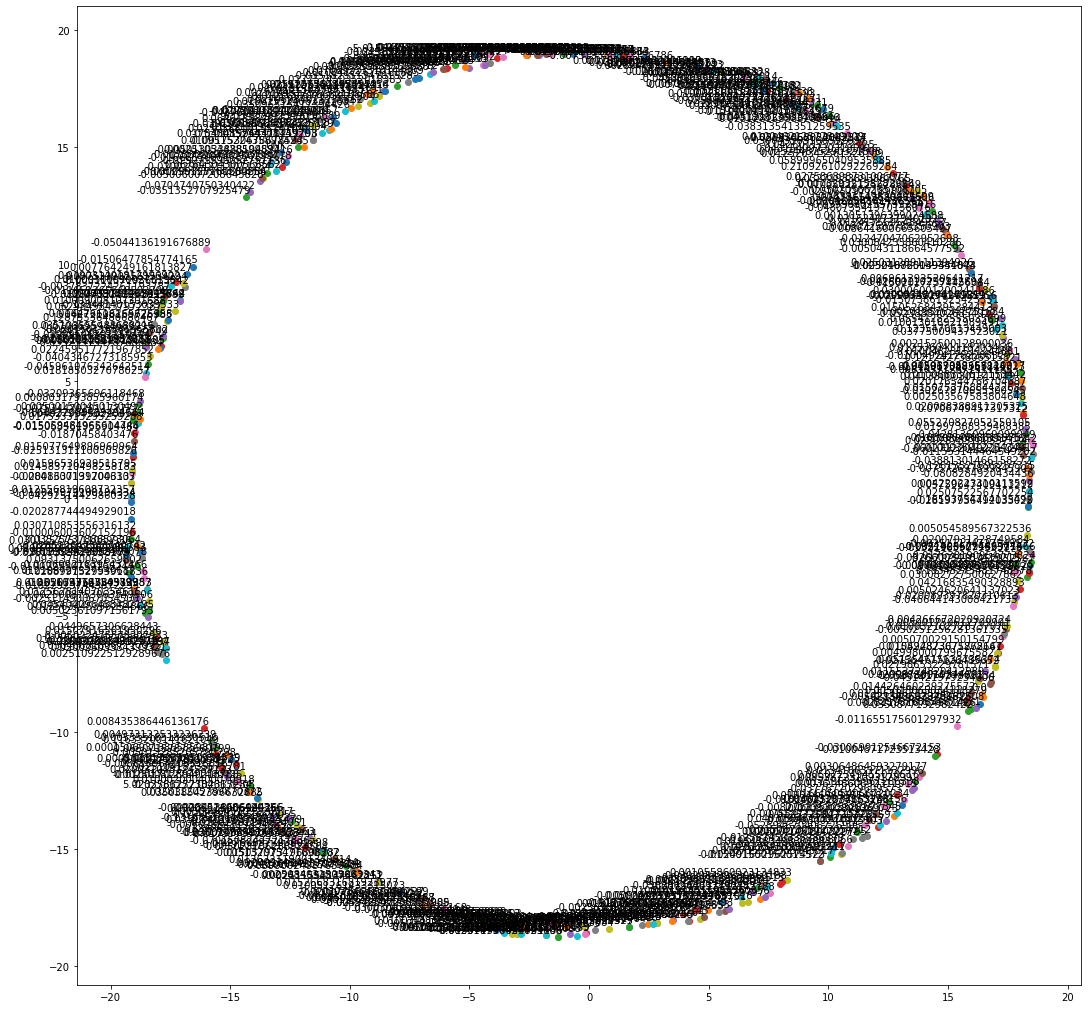

In [9]:
model.visualize()

In [38]:
d = []
dx = []
dy = []
for i in range(model.best_embeddings.shape[0]):
    x = model.best_embeddings[i][0]
    y = model.best_embeddings[i][1]
    dx.append(x)
    dy.append(y)
    d.append(math.sqrt(x **2 + y ** 2))
x_mean = np.array(dx).mean()
y_mean = np.array(dy).mean()
new_d = []
new_dx = []
new_dy = []
new_embeddings = []
for i in range(model.best_embeddings.shape[0]):
    x = model.best_embeddings[i][0] - x_mean
    y = model.best_embeddings[i][1] - y_mean
    new_embeddings.append([x, y])
    new_dx.append(x)
    new_dy.append(y)
    new_d.append(math.sqrt(x **2 + y ** 2))

In [39]:
np.array(new_d).mean(), np.array(d).mean(), np.array(new_dx).mean(), np.array(dx).mean(), np.array(new_dy).mean(), np.array(dy).mean(),

(0.6257882999006247,
 0.9999999859833595,
 -1.974481e-08,
 0.4815422,
 3.948962e-08,
 -0.5133686)

In [47]:
np.array(dx).max() , np.array(dx).min(), np.array(dy).max() , np.array(dy).min()

(1.0, -0.9999899, 0.9995224, -0.9999995)

In [46]:
np.array(new_dx).max() , np.array(new_dx).min(), np.array(new_dy).max() , np.array(new_dy).min()

(0.5184578, -1.4815321, 1.512891, -0.48663092)

In [51]:
print(np.array(d).mean(), np.array(d).std())
print(np.array(dx).mean(), np.array(dx).std())
print(np.array(dy).mean(), np.array(dy).std())

0.9999999859833595 5.086972781182611e-08
0.4815422 0.5084652
-0.5133686 0.49601716


In [52]:
model.best_embeddings[0]

array([0.98177737, 0.1900347 ], dtype=float32)

In [ ]:
skew(model.distances.flatten()), kurtosis(model.distances.flatten()), skew(model.probabilities.flatten()), kurtosis(model.probabilities.flatten())